In [10]:
# Standard libraries
from time import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display
from scipy.stats import mannwhitneyu, wilcoxon

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from lib.gallegosalas.data_fc_db import DataFCDatabase
from mesostat.metric.metric import MetricCalculator
from mesostat.stat.connectomics import offdiag_1D

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
params = {}
# params['experiment_path']  = gui_fpath("Path to data collection",  './')
# params['experiment_path'] = '/media/alyosha/Data/TE_data/yasirdata/auditory_task_all_trials'
params['experiment_path'] = '/media/alyosha/Data/TE_data/yasirdata/tactile_task_all_trials'

In [4]:
dataDB = DataFCDatabase(params)

Target range of [20, 95] timesteps amounts to [1.0, 4.7, 'seconds']
Reading channel label file
Searching for data files


In [5]:
dataDB.read_neuro_files()
len(dataDB.dataNeuronal)

IntProgress(value=0, description='Read Neuro Data:', max=6)

6

# 1.1 Cross-Correlation

m15 -0.618839041788885 1.0
m18 -0.7317429434569811 1.0
m5 -0.6270987555218525 1.0
m6 -0.6649538565838709 1.0
m7 -0.5675585945841658 1.0
m9 -0.5867444483115937 1.0


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


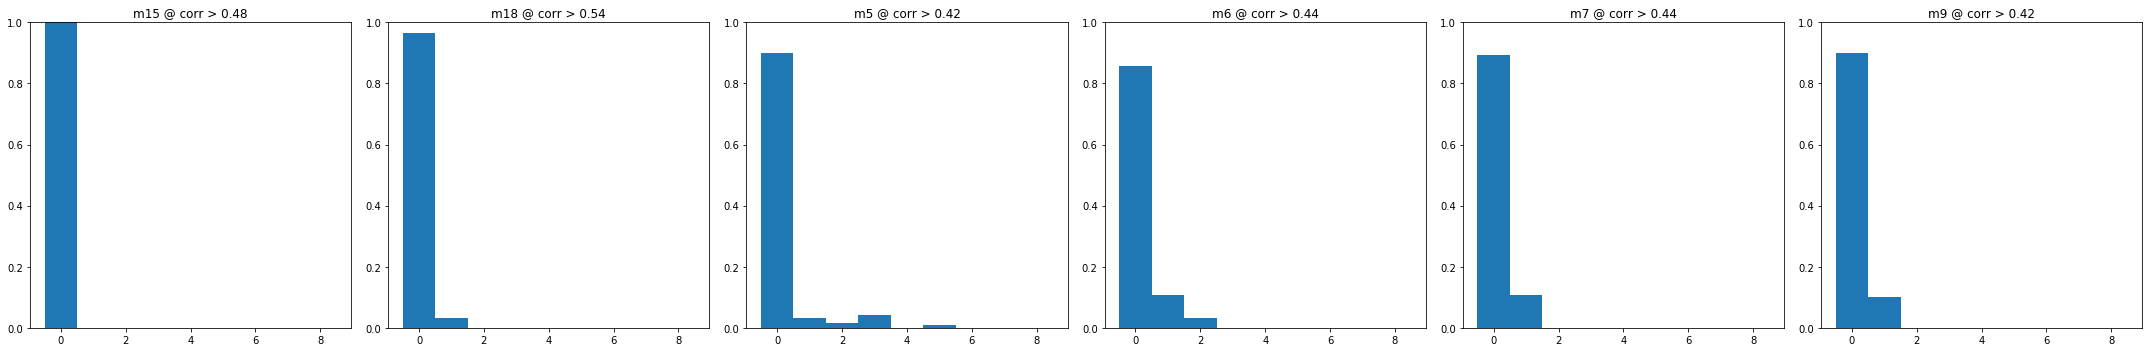

In [8]:
maxLag = 10
mc = MetricCalculator(serial=True, verbose=False)

fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(5 * len(dataDB.mice), 5), tight_layout=True)
for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
    rez = []
    for idx, row in rows.iterrows():
        mc.set_data(dataDB.dataNeuronal[idx], 'rsp', zscoreDim='p')
        rezThis = mc.metric3D('crosscorr', '', metricSettings=None, sweepSettings={'lag' : np.arange(maxLag)})
        rez += [rezThis]
        
    # Average over sessions
    rezMean = np.mean(rez, axis=0)
    rezMean = np.array([offdiag_1D(r) for r in rezMean])
    rezArgMax = np.argmax(np.abs(rezMean), axis=0)
    rezMax = np.max(np.abs(rezMean), axis=0)
    
    thrCut = np.quantile(rezMax, 0.8)
    idxCut = rezMax > thrCut
    
    print(mousename, np.min(rez), np.max(rez))
        
    ax[iMouse].set_title(mousename + ' @ corr > ' + str(np.round(thrCut, 2)))
#     ax[iMouse].plot(rezMax[idxCut], rezArgMax[idxCut], '.')
    ax[iMouse].hist(rezArgMax[idxCut], bins=np.arange(maxLag)-0.5, density=True)
    ax[iMouse].set_ylim([0, 1])
plt.show()

m15 0.0 2.3292912115497373 took time 178.52087473869324
m18 0.0 2.3185644052208074 took time 202.76708698272705
m5 0.0 2.7733953317750006 took time 199.36953568458557
m6 0.0 2.5705179742107145 took time 200.77497029304504
m7 0.0 2.5958641106455467 took time 93.29833912849426
m9 0.0 2.245270418816374 took time 191.84654545783997


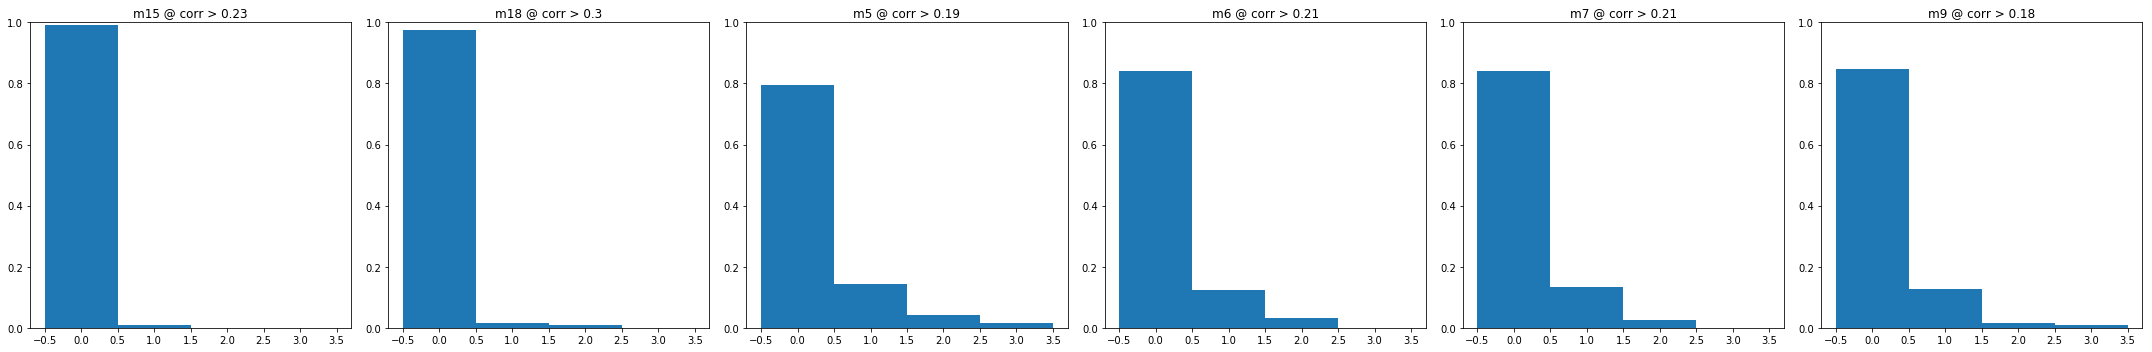

In [12]:
maxLag = 5
mc = MetricCalculator(serial=False, verbose=False)

fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(5 * len(dataDB.mice), 5), tight_layout=True)
for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    t = time()
    rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
    rez = []
    for idx, row in rows.iterrows():
        mc.set_data(dataDB.dataNeuronal[idx], 'rsp', zscoreDim='p')
        rezThis = mc.metric3D('cross_MI', '', metricSettings=None, sweepSettings={'lag' : np.arange(maxLag)})
        rez += [rezThis]
        
    # Average over sessions
    rezMean = np.mean(rez, axis=0)
    rezMean = np.array([offdiag_1D(r) for r in rezMean])
    rezArgMax = np.argmax(np.abs(rezMean), axis=0)
    rezMax = np.max(np.abs(rezMean), axis=0)
    
    thrCut = np.quantile(rezMax, 0.8)
    idxCut = rezMax > thrCut
    
    print(mousename, np.min(rez), np.max(rez), 'took time', time()-t)
        
    ax[iMouse].set_title(mousename + ' @ MI > ' + str(np.round(thrCut, 2)))
#     ax[iMouse].plot(rezMax[idxCut], rezArgMax[idxCut], '.')
    ax[iMouse].hist(rezArgMax[idxCut], bins=np.arange(maxLag)-0.5, density=True)
    ax[iMouse].set_ylim([0, 1])
plt.show()